In [1]:
# Stochastic Parameter-shift Rule

Sketch
-----

- motivation for parameter-shift rule
- review parameter-shift rule first
- diagram of PSR
- visual demonstration/plot

- limits of PSR
- motivation for SPSR
- diagram of SPSR

- visual demonstration/plot

- show how SPSR reduces to PSR

- discussion of complexity of SPRS (4x that of PSR)?
- doubly stochastic example?

In [2]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm

np.random.seed(143)

angles = np.linspace(0, 2 * np.pi, 50)

In [3]:
dev = qml.device('default.qubit', wires=2)

In [4]:
# Basic demo of the PSR in action

In [5]:
@qml.qnode(dev)
def circuit1(x):
    qml.RX(x, wires=0)
    return qml.expval(qml.PauliZ(0))

In [6]:
param = 0.5
circuit1(param)

0.8775825618903726

In [7]:
gradient = qml.grad(circuit1, argnum=0)
gradient(param)

-0.479425538604203

In [8]:
def param_shift(x):
    return 0.5 * (circuit1(x + np.pi / 2) - circuit1(x - np.pi / 2))

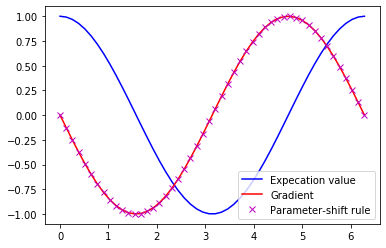

In [9]:
expvals = [circuit1(theta) for theta in angles]
grad_vals = [gradient(theta) for theta in angles]
param_shift_vals = [param_shift(theta) for theta in angles]
plt.plot(angles, expvals, 'b', label="Expecation value")
plt.plot(angles, grad_vals, 'r', label="Gradient")
plt.plot(angles, param_shift_vals, 'mx', label="Parameter-shift rule")
plt.legend();

In [10]:
# Now the Stochasic PSR

In [11]:
I = np.eye(2)
X = np.array([[0, 1], [1, 0]])
Z = np.array([[1, 0], [0, -1]])

def Generator(t, b, c):
    # the inputs will show up as Pennylane variables;
    # we have to extract their numerical values
    h = t.val * (np.kron(X, I) - 
                 b.val * np.kron(Z, X) + 
                 c.val * np.kron(I, X))
    return h

In [12]:
# This is the circuit that we will try to apply SPSR to
@qml.qnode(dev)
def circuit3(gate_pars):
    H = Generator(*gate_pars)
    qml.QubitUnitary(expm(-1j * H), wires=[0, 1])
    return qml.expval(qml.PauliZ(0))

In [13]:
# subcircuit implementing the quantum gates necessary for SPSR
# would be nicer if this was implemented in a way that was
# more easily modifiable
def SPSRgates(gate_pars, s, sign):
    H = Generator(*gate_pars)
    qml.QubitUnitary(expm(1j * (1 - s) * H), wires=[0, 1])
    # Note: we're differentiating first term of H (i.e., variable `t`)
    # Also: extra (-2) sign needed to match PL convention
    #qml.RX(sign * np.pi / 4 * (-2), wires=0) 
    # line below is equivalent to line above, 
    # but more clear (doesn't require extra sign)
    qml.QubitUnitary(expm(1j * sign * np.pi / 4 * X), wires=0)
    qml.QubitUnitary(expm(1j * s * H), wires=[0,1])

In [14]:
# obtain all expvals needed for for SPSR
@qml.qnode(dev)
def spsr_circuit3(gate_pars, s=None, sign=+1):
    SPSRgates(gate_pars, s, sign)
    return qml.expval(qml.PauliZ(0))

# QNodeCollections would be perfect here, but QNodes
# but QNodes don't seem to be compatible with `functools.partial`

b, c = -0.15, 1.6
samples = np.random.uniform(size=10)
pos_vals = np.array([[spsr_circuit3([t, b, c], s=s, sign=+1) 
                      for s in samples]
                      for t in angles])
neg_vals = np.array([[spsr_circuit3([t, b, c], s=s, sign=-1) 
                      for s in samples]
                      for t in angles])
# even 10 samples gives a good result for this example

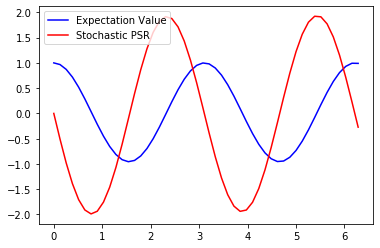

In [15]:
evals = [circuit3([t, -0.15, 1.6]) for t in angles]
spsr_vals = (pos_vals - neg_vals).mean(axis=1)

plt.plot(angles, evals, 'b', label="Expectation Value") # looks like cos(2*theta)
plt.plot(angles, spsr_vals, 'r', label="Stochastic PSR") # looks like -2 * sin(2 * theta)!
plt.legend();

In [16]:
max(evals)

1.0

In [17]:
min(spsr_vals), max(spsr_vals)

(-1.988799721424789, 1.9231462582166436)